Author: Michael Stoll\
6/7/2024\
\
In this assignment, I'm going to evaluate a number of different algorithms on a dataset and compare the accuracy of each algorithm to see which one performs the best on this particular dataset.\
\
The dataset in question is the results of a questionaire filled out by over 500 people about their mental state; in particular, participants are evaluated on an integer scale from 0 (No struggle at all) to 5 (Constant struggling) about their ability to Sleep, their Appetite, their Interest in the world around them, their Fatigue, their own sense of Worthlessness, their difficulties with Concentration, their levels of Agitation, their prevalence of Suicidal thoughts, their amount of Sleep Disturbance, their levels of Aggression, the frequency of their Panic Attacks, their sense of Hopelessness, their sense of Restlessness, and their frequency of Low Energy.\
Then, their Depression state is evaluated by 4 potential options: No Depression, Mild, Moderate, and Severe. For the sake of processing, these will be processed into integers so that the Depression State column can be used as the target.

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('depression-stats.csv', sep=',')
data = data.dropna()
#for some reason, for two entries, there is a leading integer and tab character.
#they are both under "No depression", so I converted the replace statement to a regex to handle it.
#in addition, for some reason one of the values is 50 on a questionaire that is supposed to max at 3, so I'm making sure we never go that high.
#this is sort of like using a battleaxe to open a letter, but it does certainly get the job done.
data['Depression_State'] = data['Depression_State'].str.strip().replace('(0-9)*\t*No depression','0',regex=True)
data['Depression_State'] = data['Depression_State'].str.strip().replace('Mild','1')
data['Depression_State'] = data['Depression_State'].str.strip().replace('Moderate','2')
data['Depression_State'] = data['Depression_State'].str.strip().replace('Severe','3')
data['Depression_State'] = data['Depression_State'].astype(float)
data = data.drop(data[data['Depression_State'] > 3.1].index)

Just for illustrative purposes, I'm going to show the correlation of these data points, so that I can have a rough idea for the efficiency I should be looking for as I try to predict the depression state.

<class 'pandas.core.frame.DataFrame'>
Index: 538 entries, 0 to 539
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Number             538 non-null    int64  
 1   Sleep              538 non-null    float64
 2   Appetite           538 non-null    float64
 3   Interest           538 non-null    float64
 4   Fatigue            538 non-null    float64
 5   Worthlessness      538 non-null    float64
 6   Concentration      538 non-null    float64
 7   Agitation          538 non-null    float64
 8   Suicidal           538 non-null    float64
 9   Sleep_Disturbance  538 non-null    float64
 10  Aggression         538 non-null    float64
 11  Panic_Attacks      538 non-null    float64
 12  Hopelessness       538 non-null    float64
 13  Restlessness       538 non-null    float64
 14  Low_Energy         538 non-null    float64
 15  Depression_State   538 non-null    float64
dtypes: float64(15), int64(1)
memory

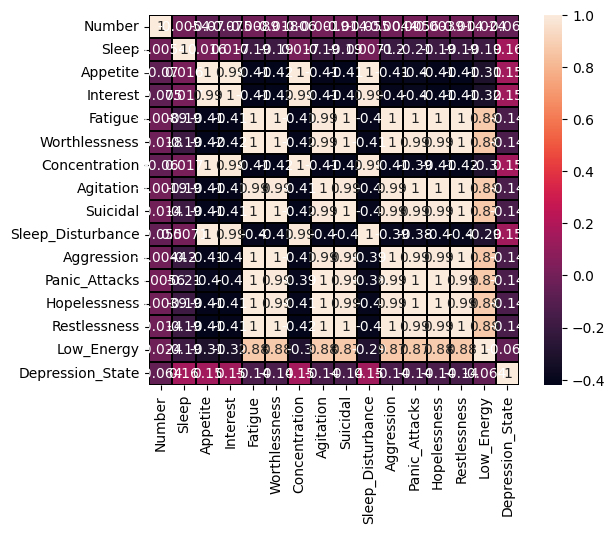

In [64]:
df = pd.DataFrame(data)
df.info()
plt.show()
sns.heatmap(df.corr(), square = True, annot= True, linewidths=.1, vmax=1, linecolor='black')#, cmap='Grays')
plt.show()

Notably, there are several cases in which there is a very strong, and sometimes even perfect, correlation between two features. One such example is the perfect alignment between Fatigue and Worthlessness.\
\
Also notable is how little the depression state correlates to anything else, comparatively. My hypothesis is that this has happened for a number of reasons: first, a sample size of 538 is not very large at all, and it's possible (and, dare I say, likely) that this is not a truly random sample of people given the nature of the distribution of these sorts of questionaires; second, working on an integer scale makes things rather black and white, and for a more accurate representation of the real world there really ought to be more room for a grey area between 1 and 2 (perhaps it would be worth it to create an analog slider instead of a multiple choice form?); and finally, unreliability in self-scoring. By this I mean I hypothesize that people answered lower on their depression state than they should have. This could be for myriad reasons, such as the stigma surrounding being labeled depressed or simply being unable to see the forest for the trees (accurately calling out Fatigue or Aggression, but being unable to see what the factors add up to), or it could simply not be at all.\
\
Regardless, I'm sticking to my guns and continuing to choose Depression State to be my target. I figure if I'm going to go through the trouble to choose the "best" algorithm, I may as well make each one of them run the gauntlet against data that isn't clean and perfect to see which one of them best handles it. I'm sure my accuracies would be much higher if I were to run Hopelessness or something but this is simply more realistic.\
\
\
Here, I'm just going to break the data into the requisite pieces for testing. I want a test size of ~20% of what I have, since I'd normally go higher but with less than 600 entries I want to make sure that I have as much to train on as possible.

In [65]:
from sklearn.model_selection import train_test_split
features = data.drop(columns=['Depression_State'])
target = data['Depression_State']
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=.20, random_state=72)

First up on the list is the random forest algorithm. The idea behind this is that, in this specific case, 75 different decision trees will be put together and evaluated against the data. 75 is an arbitrary number, but I'm finding that there is a sort of asymptote related to the number of estimators. For some reason, after you pass about 75 estimators on my machine you end up with roughly the same accuracy. For whatever reason, the more decision trees that exist, the lower the final accuracy. My hypothesis is that this is a combinatronics problem, in that when more decision trees exist there has to be more agreement and therefore lower overall accuracy since it's harder to fulifll agreement between 75 trees than 3.

Accuracy: 0.3333333333333333


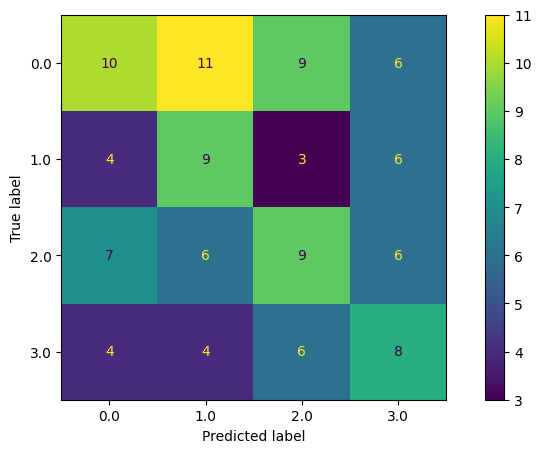

In [66]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
rf = RandomForestClassifier(n_estimators=75, random_state=420)
rf.fit(feature_train, target_train)
rfPred = rf.predict(feature_test)
rfAcc = accuracy_score(target_test, rfPred)
print("Accuracy: " + str(rfAcc))

fig, ax = plt.subplots(figsize=(10,5))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(target_test, rfPred, ax=ax)

The heatmap shows roughly what the accuracy suggests, in that the highest values tend to be along the correct diagonal, but we still end up with over 60% of the data in the false negative/false positive portions of the heatmap. Importantly, the randomized forest predicted that far more of the people polled would answer that they were at some level depressed than actually did. This could fall into my hypothesis of underperformance, or it could be a symptom of an issue with this specific algorithm. The only way to know is to run another.\
\
Next on the list is the support vector machine. Without delving too deep into specifics, the idea behind this one is that it uses the data gathered to most accurately draw the line between two classifications of data in such a way that the classifications are evenly split. My hypothesis is that this will yield a poorer result than the last one, since the data that I'm working with is numerical instead of categorical.

Accuracy: 0.4074074074074074


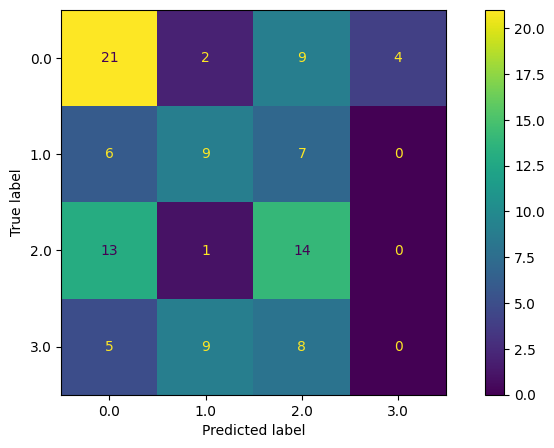

In [67]:
#support vector machine
from sklearn.svm import SVC
svm = SVC(kernel='linear', gamma=.5, C=1)
svm.fit(feature_train, target_train)
svmPred = svm.predict(feature_test)
svmAcc = accuracy_score(target_test, svmPred)
print("Accuracy: " + str(svmAcc))

fig, ax = plt.subplots(figsize=(10,5))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(target_test, svmPred, ax=ax)

There are some contradictions in the data laid before us. The accuracy claims that this is a better algorithm than the random forest, but the heatmap shows that this is because there is simply because there is a stronger prediction for the values 0 and 2 than there is in the random forest. Given that there are exactly 0 people that were correctly mapped to be a level 3 Depression state in this one vs the 8 in the previous algorithm, I would actually argue that the random forest is a stronger algorithm thanthe support vector machine, but I suppose I can't really argue with the accuracy when it's simply a projection of correctly predicted/total data.\
\
Next up is a good old-fashioned linear regression. Because of the data represented, there is going to have to be a different metric by which the algorithm is evaluated, but I belive that the eventual scatterplot is going to be just as telling as a heatmap.

mean squared error is 1.205233001646739
r^2 score is 0.07024882730108717


Text(0, 0.5, 'Depression State')

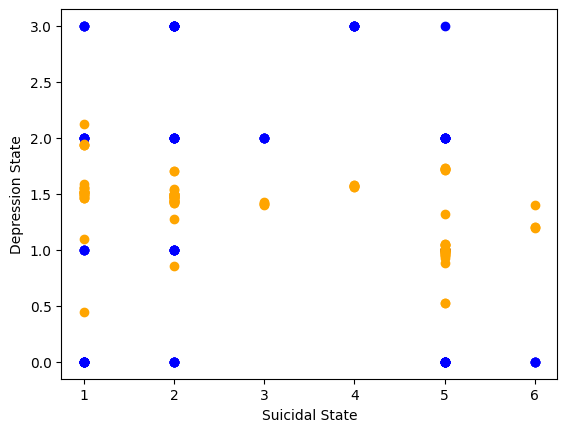

In [68]:
#linear regression
import sklearn.linear_model
import sklearn.metrics
lreg = sklearn.linear_model.LinearRegression()
lreg.fit(feature_train, target_train)
lregPred = lreg.predict(feature_test)
#despite the intention to clarify the data, I believe that this actually clouds the results.
#lregPred = np.rint(lreg.predict(feature_test))
m2e = sklearn.metrics.mean_squared_error(target_test,lregPred)
r2 = sklearn.metrics.r2_score(target_test, lregPred)
print("mean squared error is " + str(m2e))
print("r^2 score is " + str(r2))

sd = feature_test['Suicidal']

plt.scatter(sd, target_test, color='blue')
plt.scatter(sd, lregPred, color='orange')
plt.xticks()
plt.xlabel('Suicidal State')
plt.yticks()
plt.ylabel('Depression State')


Of course, a scatterplot is much different to read than a heatmap, but given the nature of the differences between the two algorithms it simply made more sense to represent them individually as I have. What's noticable in the liner regression model is the displacement of the values; obviously they don't overlap exactly with the true values, but by referencing where they congregate it's possible to estimate where the overall mean of the prediction is. For example, it's clear that the predicted Depression States of patients trends lower than the real value based solely upon the provided Suicidal State metric. Of course, in this comparison of apples and oranges it's difficult to determine and exact "accuracy" for this algorithm, but it's simply clear that if there is any overlap between predicted and real values, it's miniscule compared to the rest of the provided data.\
So, this algorithm takes a strong third place in the three algorithms yet assessed across this data.\
\
Now we move onto the decision tree learner. In essence, the decision tree is a simpler version of the random forest algorithm (which would explain tree vs forest). Basically, the decision tree approach is just the random forest algorithm if there was only 1 tree from which to build a model.

Accuracy: 0.2962962962962963


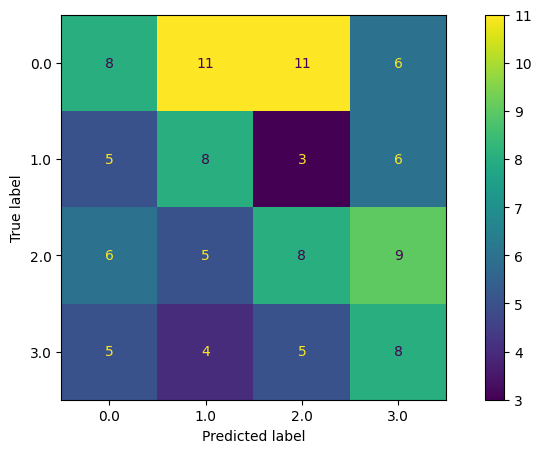

In [69]:
#decision tree learner
from sklearn.tree import DecisionTreeRegressor
rt = DecisionTreeRegressor()
rt.fit(feature_train, target_train)
rtPred = rt.predict(feature_test)
rtAcc = accuracy_score(target_test, rtPred)
print("Accuracy: " + str(rtAcc))

fig, ax = plt.subplots(figsize=(10,5))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(target_test, rtPred, ax=ax)

Though this is a slightly better representation (in my opinion) of the heatmap, it's clear by the accurancy and the heatmap together that the trend of the data still diverges into false negative/false positive territory too strongly for this algorithm to be strongly considered to be the "best" choice. Simplicity of input begats simplicity of output, and in this case that simplicity is a detriment instead of a benefit. Therefore, it's now time to move on.\
\
Next up is gradient boosting. This one works on the idea that you can put many things that learn a little together and end up with one thing that has learned a lot. For this experiment, I've chosen 50 estimators to learn 5% of the data each, so that when the combined they hopefully have far over the requisite amount of data and can accurately predict what should come next with the advent of Major data.

Accuracy: 0.4166666666666667


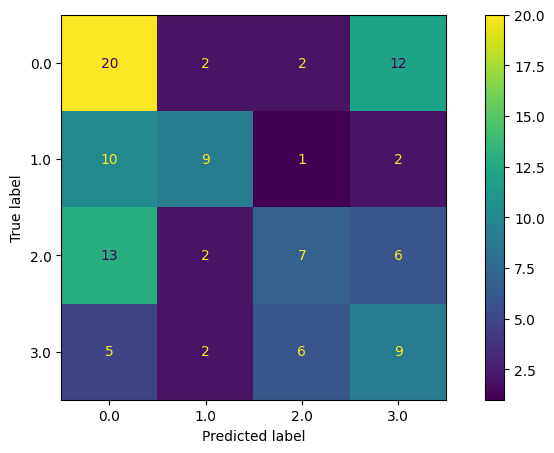

In [70]:
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=50, learning_rate=.05, random_state= 301,
                                max_features=13)
gb.fit(feature_train, target_train)
gbPred = gb.predict(feature_test)
gbAcc = accuracy_score(target_test, gbPred)
print("Accuracy: " + str(gbAcc))

fig, ax = plt.subplots(figsize=(10,5))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(target_test, gbPred, ax=ax)

As is clear in the heatmap, this algorithm somwhat combines the best of both worlds, in that there is a (somewhat) strong correlation across the main diagonal, but then that there is also a significant (yet nearly balanced) amount of data to offset both the false positive and false negative results in this heatmap to return almost exclusively the main sequence model.\
\
Obviously, we haven't come across a model that does much better than the one above, but I don't think that was ever really the point. As previously mentioned, the data already had a "weak" correlation before any of these tests started, and so the errors that have been omnipresent since day one continue to plague the data scientists that process this data in any way.\
\
However, I strongly believe that this gradient boosting algorithm is the strongest one of the above listed algorithms. The numbers don't explicitly agree, but I strongly believe that this correlation of the best of both worlds leads to the "best" algorithm I was looking for for this data, since I want the best well-rounded algorithm and for this dataset this appears to be it.